In [3]:
library(tidyverse)
library(doParallel)
library(foreach)

library(caret)
library(rpart)
library(ipred)

In [4]:
ames <- ames <- AmesHousing::make_ames()
index <- sample(1:dim(ames)[1], 0.7*dim(ames)[1])
ames_train <- ames[index,]
ames_test <- ames[-index,]

## 배깅
- 부트스트랩 예측모델 
- 예측 모델의 여러 버전을 맞춘 다음 이를 집계 (앙상블)
- 회귀문제 : 개별 기본 회귀모형의 예측을 함께 평균화 하여 새로운 예측이 이루어짐
- 분류문제 : 개별 기본 분류모형의 투표 (보팅) 혹은 추정된 클래스 확률을 함꼐 평균화 하여 결합

- **개별 기본 모형의 분산을 줄임 (평균화는 분산을 줄임)**
* 불안정하고 분산이 큰 기본 모형에 대해 잘 작동
* 안정적이거나 편향이 큰 기본 모형에 대해서는 개선이 덜함


- 노이즈가 많거나 강력한 변수가 여러 개인 데이터 세트에는 트리수가 많이 필요
- 많은 트리를 사용하면 과적합이 발생하지 않음 (but 시간이 오래걸림)
- K-fold CV를 수행

* OOB샘플을 사용하여 예측 성능에 대한 자체 내부 평가 가능
- 데이터 세트가 충분히 크다고 가정할 때(n > 1000) K-fold CV와 잘 비교
- 데이터 세트가 커지고, 배깅 반복이 증가함에 따라 예측 성능을 위한 프록시로 OOB오류 추정치를 사용

### 트리상관관계

#### - 나무를 배깅할 대 문제 : 모델 구축 단계는 독립적이지만, 배깅트리는 원래 모든 트리의 모든 분할에서 고려되게 때문에, 서로 완전히 독립적이지 않음

#### - 다른 부트스트랩 샘플이라도, 강력한 관계로 인해, 일반적으로 서로 유사한 구조를 가짐
### => 상관관계를 줄이고, 전체 앙상블의 정확도를 개선하는 랜덤포레스트 필요

### 구현
### ```ipred::bagging()```
- ```nbagg``` : 반복 횟수
- ```coob = TRUE``` : OOB 오류율을 표시
- ```control = rpart.control()``` : ```minsplit``` : 개별 나무의 분리 수, ```cp``` : 비용복잡도

In [ ]:
set.seed(123)
ames_bag1 <- bagging(
  formula = Sale_Price ~ .,
  data = ames_train,
  nbagg = 100,  
  coob = TRUE,
  control = rpart.control(minsplit = 2, cp = 0)
)

In [7]:
ames_bag1


Bagging regression trees with 100 bootstrap replications 

Call: bagging.data.frame(formula = Sale_Price ~ ., data = ames_train, 
    nbagg = 100, coob = TRUE, control = rpart.control(minsplit = 2, 
        cp = 0))

Out-of-bag estimate of root mean squared error:  27979.33 


### 10-folds CV 배깅

In [11]:
ames_bag2 <- train(
    Sale_Price ~ .,
    data = ames_train,
    method = "treebag",
    trControl = trainControl(method = "cv", number = 10),
    nbagg = 200,
    control = rpart.control(minsplit = 2, cp = 0)
)
ames_bag2

Bagged CART 

2051 samples
  80 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1845, 1846, 1845, 1845, 1847, 1846, ... 
Resampling results:

  RMSE     Rsquared   MAE     
  26844.1  0.8906583  16440.84


In [12]:
attributes(ames_bag2)

$names
 [1] "method"       "modelInfo"    "modelType"    "results"      "pred"        
 [6] "bestTune"     "call"         "dots"         "metric"       "control"     
[11] "finalModel"   "preProcess"   "trainingData" "ptype"        "resample"    
[16] "resampledCM"  "perfNames"    "maximize"     "yLimits"      "times"       
[21] "levels"       "terms"        "coefnames"    "contrasts"    "xlevels"     

$class
[1] "train"         "train.formula"

<img src = "https://bradleyboehmke.github.io/HOML/08-bagging_files/figure-html/n-bags-plot-1.png"> 

* 일반적으로 나무가 많을수록 성능이 좋음
- 많은 트리를 추가함에 따라, 더 많은 고분산 결정트리에 대해 평균을 냄
- 초기에 편차(오류)가 크게 감소하지만 결국 오류는 일반적으로 평평해지고, 적절한 수의 트리에 도달함을 알 수 있음
- **오류를 안정화하기 위해서는 50~100개의 트리면 충분**

### 병렬화
- 배깅 프로세스에는 서로 완전히 독립적인 각 부트스트랩 샘플에 모델을 맞추는 작업이 포함
- 각 모델을 병렬로 학습할 수 있고, 결과를 최종 모델에 대해 집계

In [15]:
cl <- makeCluster(8) 
registerDoParallel(cl)

In [16]:
predictions <- foreach(
  icount(160), 
  .packages = "rpart", 
  .combine = cbind
  ) %dopar% {
    index <- sample(nrow(ames_train), replace = TRUE)
    ames_train_boot <- ames_train[index, ]  
  
    bagged_tree <- rpart(
      Sale_Price ~ ., 
      control = rpart.control(minsplit = 2, cp = 0),
      data = ames_train_boot
      ) 
    
    predict(bagged_tree, newdata = ames_test)
}

In [18]:
predictions %>% head

,result.1,result.2,result.3,result.4,result.5,result.6,result.7,result.8,result.9,result.10,...,result.151,result.152,result.153,result.154,result.155,result.156,result.157,result.158,result.159,result.160
1,132000,139000,145000,147000,147000,154000,157500,180000,153000,145250,...,140000,171500,169000,157900,145250,180000,163000,166800,256000,242500
2,183000,244000,244000,174850,244000,242000,256000,200000,244000,244000,...,237500,244000,159500,235000,242000,163000,229000,169000,196750,160000
3,155000,226500,225000,180000,236500,189000,213750,180000,190000,212000,...,180000,212000,180000,191500,180000,212000,236500,213750,180000,180000
4,171500,189900,187000,186500,168000,185000,163000,171500,181000,171500,...,170000,190000,168000,198444,163000,195500,181000,185101,172400,198444
5,155000,221370,213750,324000,162500,180500,209500,247900,188500,155000,...,214000,278000,270000,212000,212000,392000,214000,294464,193800,217500
6,349265,315000,375000,310000,403000,310000,318300,582933,350000,337000,...,556581,305000,460000,361919,438780,361919,457347,370000,410000,325000


In [27]:
predictions %>%
  as.data.frame() %>%
  mutate(
    observation = 1:n(),
    actual = ames_test$Sale_Price) %>% 
  tidyr::gather(tree, predicted, -c(observation, actual)) %>% head

,observation,actual,tree,predicted
,<int>,<int>,<chr>,<dbl>
1,1,172000,result.1,132000
2,2,244000,result.1,183000
3,3,213500,result.1,155000
4,4,175900,result.1,171500
5,5,212000,result.1,155000
6,6,538000,result.1,349265


In [29]:
predictions %>%
  as.data.frame() %>%
  mutate(
    observation = 1:n(),
    actual = ames_test$Sale_Price) %>% 
  tidyr::gather(tree, predicted, -c(observation, actual)) %>% 
  group_by(observation) %>%
  mutate(tree = stringr::str_extract(tree, '\\d+') %>% as.numeric()) %>%
  ungroup() %>%
  arrange(observation, tree) %>% head

observation,actual,tree,predicted
<int>,<int>,<dbl>,<dbl>
1,172000,1,132000
1,172000,2,139000
1,172000,3,145000
1,172000,4,147000
1,172000,5,147000
1,172000,6,154000


In [30]:
predictions %>%
  as.data.frame() %>%
  mutate(
    observation = 1:n(),
    actual = ames_test$Sale_Price) %>%
  tidyr::gather(tree, predicted, -c(observation, actual)) %>%
  group_by(observation) %>%
  mutate(tree = stringr::str_extract(tree, '\\d+') %>% as.numeric()) %>%
  ungroup() %>%
  arrange(observation, tree) %>%
  group_by(observation) %>%
  mutate(avg_prediction = cummean(predicted)) %>%
  group_by(tree) %>%
  summarize(RMSE = RMSE(avg_prediction, actual)) %>% head

tree,RMSE
<dbl>,<dbl>
1,41221.63
2,37230.25
3,34529.76
4,33050.74
5,32720.39
6,32073.40


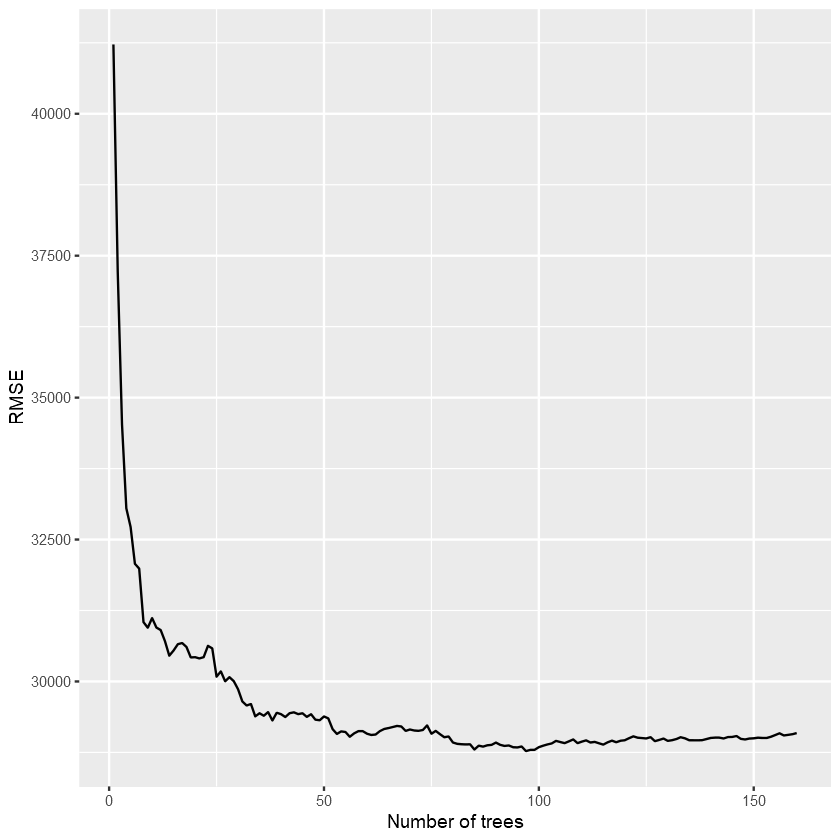

In [19]:
predictions %>%
  as.data.frame() %>%
  mutate(
    observation = 1:n(),
    actual = ames_test$Sale_Price) %>%
  tidyr::gather(tree, predicted, -c(observation, actual)) %>%
  group_by(observation) %>%
  mutate(tree = stringr::str_extract(tree, '\\d+') %>% as.numeric()) %>%
  ungroup() %>%
  arrange(observation, tree) %>%
  group_by(observation) %>%
  mutate(avg_prediction = cummean(predicted)) %>%
  group_by(tree) %>%
  summarize(RMSE = RMSE(avg_prediction, actual)) %>%
  ggplot(aes(tree, RMSE)) +
  geom_line() +
  xlab('Number of trees')

In [20]:
stopCluster(cl)

### 변수 중요도

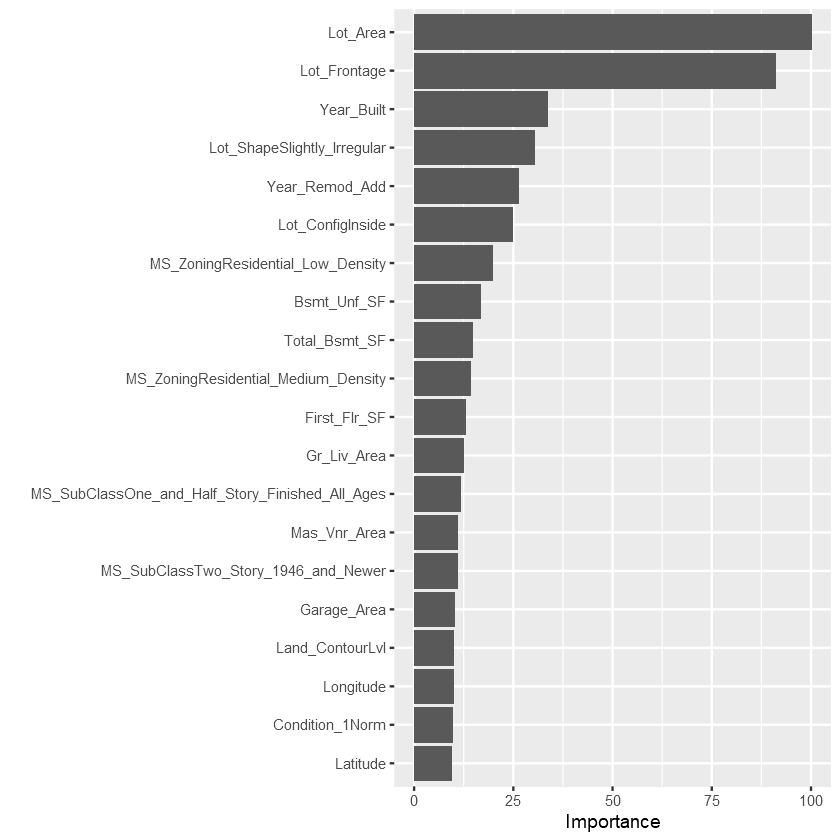

In [26]:
vip::vip(ames_bag2, num_features = 20)

### PDP

Warning message:
"Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead."
Warning message:
"Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead."
Warning message:
"Use of `object[[1L]]` is discouraged. Use `.data[[1L]]` instead."
Warning message:
"Use of `object[["yhat"]]` is discouraged. Use `.data[["yhat"]]` instead."


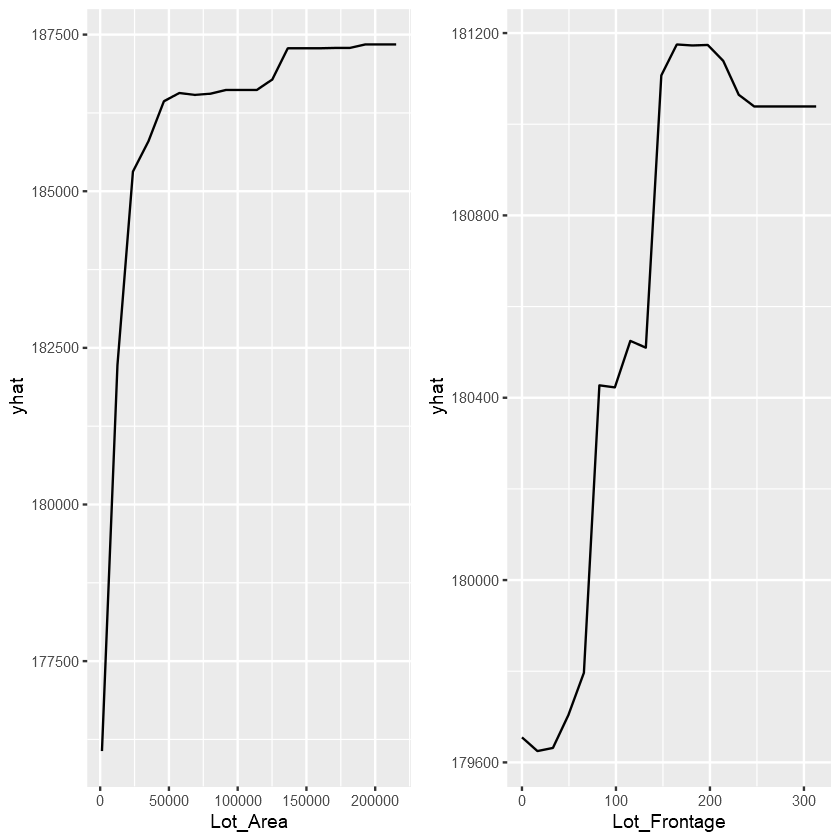

In [28]:
p1 <- pdp::partial(
  ames_bag2, 
  pred.var = "Lot_Area",
  grid.resolution = 20
  ) %>% 
  autoplot()

p2 <- pdp::partial(
  ames_bag2, 
  pred.var = "Lot_Frontage", 
  grid.resolution = 20
  ) %>% 
  autoplot()

gridExtra::grid.arrange(p1, p2, nrow = 1)